In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from haversine import haversine
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import LearningCurveDisplay
import pickle

In [3]:
from google.cloud import bigquery

In [4]:
client = bigquery.Client()

In [5]:

query = """ SELECT
          *
        FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips`
        WHERE
            pickup_latitude IS NOT NULL
            AND pickup_longitude IS NOT NULL
            AND dropoff_latitude IS NOT NULL
            AND dropoff_longitude IS NOT NULL
            AND pickup_census_tract IS NOT NULL
            AND dropoff_census_tract IS NOT NULL
            AND fare IS NOT NULL
            AND pickup_community_area IS NOT NULL
            AND dropoff_community_area IS NOT NULL
        LIMIT 20000
"""

In [6]:
df = client.query(query).result().to_dataframe()
df

unique_key  \
0      6e3805494f154e878aaa1d1e4f4b9607155437bc   
1      c92b6caaa4711acf4b585d6962de26c757c2625c   
2      284c05d67d3920e5fc53b8758eba06e4e87305ab   
3      72065f51ea9783ed9423d515de2179c1c3344473   
4      8a643b9e55967ac19e19297d3f330eea4f699780   
...                                         ...   
19995  104e561a22bce892b1ffa475cf0cfb7df0a301b0   
19996  ab8cebde46617ae30037310f2502d49da8a5f101   
19997  174b1996d1e5fcbd90b9341b15f966b584ca7122   
19998  0219cedda2b5649654e4134c3ffbcb1f2f1a33ad   
19999  ab573031b2ac98d48566feb631c76a33d0697837   

                                                 taxi_id  \
0      b2b3941b38fad492b956dc4ec546dab16697d7071bcb02...   
1      c037f72571661a73d9cd7575374482ec91c4ca9ec869d0...   
2      282f6fefb5261b5b2642a9b4702b76641a0badbd14f304...   
3      1eaf50df810f85b1dbcb7a12f35850df23a34ff48380a6...   
4      768431d476300aa4759020069a99c25201a9ce1c21e94e...   
...                                                  ...   
19995  c0250f358cae01c5319aeb7b39827e53f9a2259eb32e4c...   
19996  f1c4fb891f4812fb2865e801d2185b401283b34401b71f...   
19997  d5a39ffd1a6f7f670ef5196342c025b9ad62aa127b8f56...   
19998  cbdd490649df25aa771979bed8930b199d27a990ccdb42...   
19999  01480513a7f6f4664d6cc4c41ff3043ae6ecbc8cb17404...   

           trip_start_timestamp        trip_end_timestamp  trip_seconds  \
0     2018-10-26 18:45:00+00:00 2018-10-26 19:00:00+00:00           300   
1     2018-10-18 22:15:00+00:00 2018-10-18 22:30:00+00:00           480   
2     2018-10-26 09:30:00+00:00 2018-10-26 09:45:00+00:00          1020   
3     2018-10-18 20:30:00+00:00 2018-10-18 20:45:00+00:00          1020   
4     2018-10-19 14:30:00+00:00 2018-10-19 14:45:00+00:00          1020   
...                         ...                       ...           ...   
19995 2018-10-24 10:00:00+00:00 2018-10-24 10:15:00+00:00           660   
19996 2018-10-19 09:00:00+00:00 2018-10-19 09:00:00+00:00             0   
19997 2018-10-26 14:15:00+00:00 2018-10-26 14:30:00+00:00          1200   
19998 2018-10-26 16:30:00+00:00 2018-10-26 16:30:00+00:00           420   
19999 2018-10-19 12:45:00+00:00 2018-10-19 13:00:00+00:00           540   

       trip_miles  pickup_census_tract  dropoff_census_tract  \
0             0.7          17031080201           17031081100   
1             1.4          17031071500           17031081500   
2             2.8          17031071300           17031839100   
3             0.0          17031161000           17031031400   
4             0.1          17031080300           17031280100   
...           ...                  ...                   ...   
19995         0.0          17031280100           17031320100   
19996         0.0          17031280100           17031280100   
19997         0.3          17031280100           17031063200   
19998         1.2          17031280100           17031081600   
19999         0.0          17031280100           17031081201   

       pickup_community_area  dropoff_community_area  ...  extras  trip_total  \
0                          8                       8  ...     0.0        5.50   
1                          7                       8  ...     1.0        8.25   
2                          7                      32  ...     0.0       15.25   
3                         16                       3  ...     0.0       17.10   
4                          8                      28  ...     1.0       14.10   
...                      ...                     ...  ...     ...         ...   
19995                     28                      32  ...     0.0        9.75   
19996                     28                      28  ...     0.0        3.25   
19997                     28                       6  ...     0.0       18.50   
19998                     28                       8  ...     0.0        8.75   
19999                     28                       8  ...     0.0        8.25   

       payment_type                            company  pick

In [7]:
df.shape

(20000, 23)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              20000 non-null  object             
 1   taxi_id                 20000 non-null  object             
 2   trip_start_timestamp    20000 non-null  datetime64[ns, UTC]
 3   trip_end_timestamp      20000 non-null  datetime64[ns, UTC]
 4   trip_seconds            20000 non-null  Int64              
 5   trip_miles              20000 non-null  float64            
 6   pickup_census_tract     20000 non-null  Int64              
 7   dropoff_census_tract    20000 non-null  Int64              
 8   pickup_community_area   20000 non-null  Int64              
 9   dropoff_community_area  20000 non-null  Int64              
 10  fare                    20000 non-null  float64            
 11  tips                    20000 non-null  f

In [9]:
# Convert the datetime column to datetime dtype
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])

# Convert datetime values to the desired format
df['trip_start_timestamp'] = df['trip_start_timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [10]:
df.head()

unique_key  \
0  6e3805494f154e878aaa1d1e4f4b9607155437bc   
1  c92b6caaa4711acf4b585d6962de26c757c2625c   
2  284c05d67d3920e5fc53b8758eba06e4e87305ab   
3  72065f51ea9783ed9423d515de2179c1c3344473   
4  8a643b9e55967ac19e19297d3f330eea4f699780   

                                             taxi_id trip_start_timestamp  \
0  b2b3941b38fad492b956dc4ec546dab16697d7071bcb02...  2018-10-26 18:45:00   
1  c037f72571661a73d9cd7575374482ec91c4ca9ec869d0...  2018-10-18 22:15:00   
2  282f6fefb5261b5b2642a9b4702b76641a0badbd14f304...  2018-10-26 09:30:00   
3  1eaf50df810f85b1dbcb7a12f35850df23a34ff48380a6...  2018-10-18 20:30:00   
4  768431d476300aa4759020069a99c25201a9ce1c21e94e...  2018-10-19 14:30:00   

         trip_end_timestamp  trip_seconds  trip_miles  pickup_census_tract  \
0 2018-10-26 19:00:00+00:00           300         0.7          17031080201   
1 2018-10-18 22:30:00+00:00           480         1.4          17031071500   
2 2018-10-26 09:45:00+00:00          1020         2.8          17031071300   
3 2018-10-18 20:45:00+00:00          1020         0.0          17031161000   
4 2018-10-19 14:45:00+00:00          1020         0.1          17031080300   

   dropoff_census_tract  pickup_community_area  dropoff_community_area  ...  \
0           17031081100                      8                       8  ...   
1           17031081500                      7                       8  ...   
2           17031839100                      7                      32  ...   
3           17031031400                     16                       3  ...   
4           17031280100                      8                      28  ...   

   extras  trip_total  payment_type                            company  \
0     0.0        5.50          Cash          Taxi Affiliation Services   
1     1.0        8.25          Cash          Star North Management LLC   
2     0.0       15.25   Credit Card          Taxi Affiliation Services   
3     0.0       17.10   Credit Card          Taxi Affiliation Services   
4     1.0       14.10   Credit Card  Blue Ribbon Taxi Association Inc.   

   pickup_latitude pickup_longitude                       pickup_location  \
0        41.909496       -87.630964   POINT (-87.630963601 41.9094956686)   
1        41.914616       -87.631717  POINT (-87.6317173661 41.9146162864)   
2        41.921778       -87.641460  POINT (-87.6414597588 41.9217783562)   
3        41.949974       -87.730684  POINT (-87.7306842554 41.9499744545)   
4        41.907492       -87.635760  POINT (-87.6357600901 41.9074919303)   

   dropoff_latitude  dropoff_longitude                      dropoff_location  
0         41.900221         -87.629105  POINT (-87.6291051864 41.9002212967)  
1         41.892508         -87.626215  POINT (-87.6262149064 41.8925077809)  
2         41.880994         -87.632746  POINT (-87.6327464887 41.8809944707)  
3         41.962179         -87.645379   POINT (-87.6453787624 41.962178629)  
4         41.885300         -87.642808  POINT (-87.6428084655 41.8853000224)  

[5 rows x 23 columns]

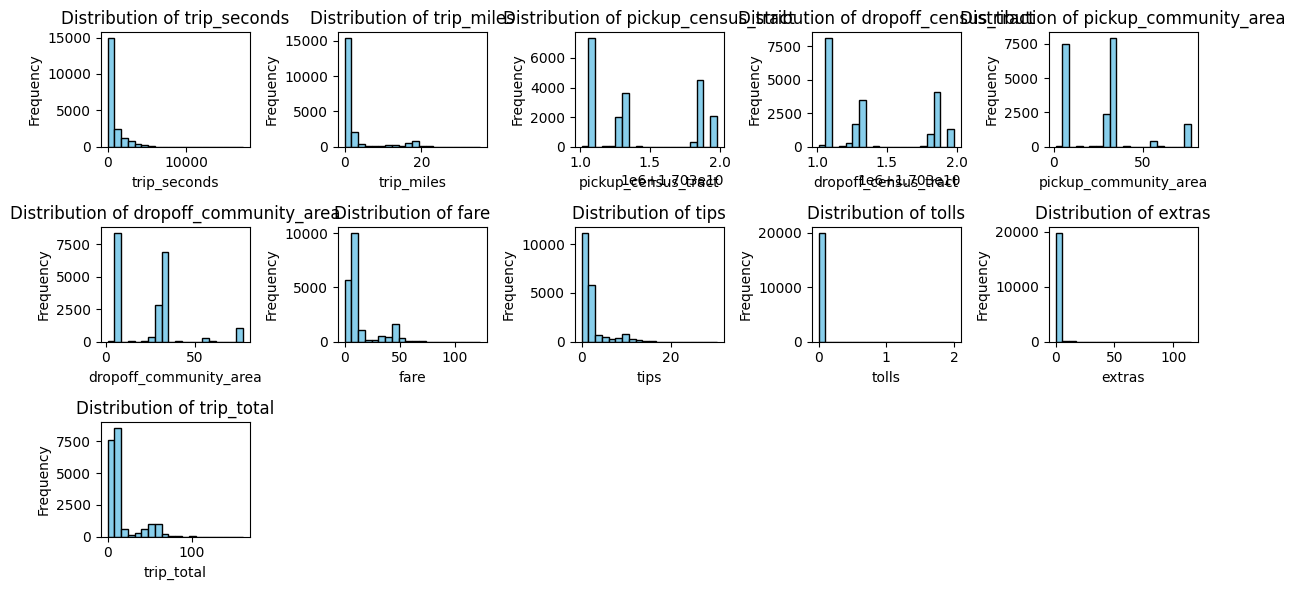

In [11]:
test_df = df
test_df.fillna(0, inplace=True)

features = ['trip_seconds', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras', 'trip_total']

num_features = len(features)
num_cols = 5
num_rows = (num_features - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, feature in enumerate(features):
    row_index = i // num_cols
    col_index = i % num_cols

    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]

    ax.hist(df[feature], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for i in range(num_features, num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.show()

In [12]:
# code ini diambil dari kaggle dan dimodifikasi
# Yang dimodifikasi: Census tract tidak di drop
to_drop = ["taxi_id",
           "tips",
           "trip_seconds",
           "trip_miles",
           "extras",
           "trip_total",
           "company",
           "tolls",
           "payment_type",
           "trip_end_timestamp"]

# Drop selected fields in place
df.drop(to_drop, inplace=True, axis=1)

In [13]:
df.head()

unique_key trip_start_timestamp  \
0  6e3805494f154e878aaa1d1e4f4b9607155437bc  2018-10-26 18:45:00   
1  c92b6caaa4711acf4b585d6962de26c757c2625c  2018-10-18 22:15:00   
2  284c05d67d3920e5fc53b8758eba06e4e87305ab  2018-10-26 09:30:00   
3  72065f51ea9783ed9423d515de2179c1c3344473  2018-10-18 20:30:00   
4  8a643b9e55967ac19e19297d3f330eea4f699780  2018-10-19 14:30:00   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0          17031080201           17031081100                      8   
1          17031071500           17031081500                      7   
2          17031071300           17031839100                      7   
3          17031161000           17031031400                     16   
4          17031080300           17031280100                      8   

   dropoff_community_area   fare  pickup_latitude  pickup_longitude  \
0                       8   5.50        41.909496        -87.630964   
1                       8   7.25        41.914616        -87.631717   
2                      32  11.75        41.921778        -87.641460   
3                       3  14.25        41.949974        -87.730684   
4                      28  10.75        41.907492        -87.635760   

                        pickup_location  dropoff_latitude  dropoff_longitude  \
0   POINT (-87.630963601 41.9094956686)         41.900221         -87.629105   
1  POINT (-87.6317173661 41.9146162864)         41.892508         -87.626215   
2  POINT (-87.6414597588 41.9217783562)         41.880994         -87.632746   
3  POINT (-87.7306842554 41.9499744545)         41.962179         -87.645379   
4  POINT (-87.6357600901 41.9074919303)         41.885300         -87.642808   

                       dropoff_location  
0  POINT (-87.6291051864 41.9002212967)  
1  POINT (-87.6262149064 41.8925077809)  
2  POINT (-87.6327464887 41.8809944707)  
3   POINT (-87.6453787624 41.962178629)  
4  POINT (-87.6428084655 41.8853000224)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   unique_key              20000 non-null  object 
 1   trip_start_timestamp    20000 non-null  object 
 2   pickup_census_tract     20000 non-null  Int64  
 3   dropoff_census_tract    20000 non-null  Int64  
 4   pickup_community_area   20000 non-null  Int64  
 5   dropoff_community_area  20000 non-null  Int64  
 6   fare                    20000 non-null  float64
 7   pickup_latitude         20000 non-null  float64
 8   pickup_longitude        20000 non-null  float64
 9   pickup_location         20000 non-null  object 
 10  dropoff_latitude        20000 non-null  float64
 11  dropoff_longitude       20000 non-null  float64
 12  dropoff_location        20000 non-null  object 
dtypes: Int64(4), float64(5), object(4)
memory usage: 2.1+ MB


In [16]:
df.drop(columns=['unique_key'], inplace=True, axis=1)
df.head()

trip_start_timestamp  pickup_census_tract  dropoff_census_tract  \
0  2018-10-26 18:45:00          17031080201           17031081100   
1  2018-10-18 22:15:00          17031071500           17031081500   
2  2018-10-26 09:30:00          17031071300           17031839100   
3  2018-10-18 20:30:00          17031161000           17031031400   
4  2018-10-19 14:30:00          17031080300           17031280100   

   pickup_community_area  dropoff_community_area   fare  pickup_latitude  \
0                      8                       8   5.50        41.909496   
1                      7                       8   7.25        41.914616   
2                      7                      32  11.75        41.921778   
3                     16                       3  14.25        41.949974   
4                      8                      28  10.75        41.907492   

   pickup_longitude                       pickup_location  dropoff_latitude  \
0        -87.630964   POINT (-87.630963601 41.9094956686)         41.900221   
1        -87.631717  POINT (-87.6317173661 41.9146162864)         41.892508   
2        -87.641460  POINT (-87.6414597588 41.9217783562)         41.880994   
3        -87.730684  POINT (-87.7306842554 41.9499744545)         41.962179   
4        -87.635760  POINT (-87.6357600901 41.9074919303)         41.885300   

   dropoff_longitude                      dropoff_location  
0         -87.629105  POINT (-87.6291051864 41.9002212967)  
1         -87.626215  POINT (-87.6262149064 41.8925077809)  
2         -87.632746  POINT (-87.6327464887 41.8809944707)  
3         -87.645379   POINT (-87.6453787624 41.962178629)  
4         -87.642808  POINT (-87.6428084655 41.8853000224)

In [17]:
# code ini diambil dari kaggle dan dimodifikasi
# Yang dimodifikasi: trip_start_timestamp diubah kedalam datetime terlebih dahulu
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
df['weekday'] = df['trip_start_timestamp'].map(lambda x: x.weekday())
df['time'] = df['trip_start_timestamp'].map(lambda x: x.hour*4 + round(x.minute/15))

df.head()

trip_start_timestamp  pickup_census_tract  dropoff_census_tract  \
0  2018-10-26 18:45:00          17031080201           17031081100   
1  2018-10-18 22:15:00          17031071500           17031081500   
2  2018-10-26 09:30:00          17031071300           17031839100   
3  2018-10-18 20:30:00          17031161000           17031031400   
4  2018-10-19 14:30:00          17031080300           17031280100   

   pickup_community_area  dropoff_community_area   fare  pickup_latitude  \
0                      8                       8   5.50        41.909496   
1                      7                       8   7.25        41.914616   
2                      7                      32  11.75        41.921778   
3                     16                       3  14.25        41.949974   
4                      8                      28  10.75        41.907492   

   pickup_longitude                       pickup_location  dropoff_latitude  \
0        -87.630964   POINT (-87.630963601 41.9094956686)         41.900221   
1        -87.631717  POINT (-87.6317173661 41.9146162864)         41.892508   
2        -87.641460  POINT (-87.6414597588 41.9217783562)         41.880994   
3        -87.730684  POINT (-87.7306842554 41.9499744545)         41.962179   
4        -87.635760  POINT (-87.6357600901 41.9074919303)         41.885300   

   dropoff_longitude                      dropoff_location  weekday  time  
0         -87.629105  POINT (-87.6291051864 41.9002212967)        4    75  
1         -87.626215  POINT (-87.6262149064 41.8925077809)        3    89  
2         -87.632746  POINT (-87.6327464887 41.8809944707)        4    38  
3         -87.645379   POINT (-87.6453787624 41.962178629)        3    82  
4         -87.642808  POINT (-87.6428084655 41.8853000224)        4    58

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_census_tract     20000 non-null  Int64         
 2   dropoff_census_tract    20000 non-null  Int64         
 3   pickup_community_area   20000 non-null  Int64         
 4   dropoff_community_area  20000 non-null  Int64         
 5   fare                    20000 non-null  float64       
 6   pickup_latitude         20000 non-null  float64       
 7   pickup_longitude        20000 non-null  float64       
 8   pickup_location         20000 non-null  object        
 9   dropoff_latitude        20000 non-null  float64       
 10  dropoff_longitude       20000 non-null  float64       
 11  dropoff_location        20000 non-null  object        
 12  weekday                 20000 non-null  int64 

In [19]:
df

trip_start_timestamp  pickup_census_tract  dropoff_census_tract  \
0      2018-10-26 18:45:00          17031080201           17031081100   
1      2018-10-18 22:15:00          17031071500           17031081500   
2      2018-10-26 09:30:00          17031071300           17031839100   
3      2018-10-18 20:30:00          17031161000           17031031400   
4      2018-10-19 14:30:00          17031080300           17031280100   
...                    ...                  ...                   ...   
19995  2018-10-24 10:00:00          17031280100           17031320100   
19996  2018-10-19 09:00:00          17031280100           17031280100   
19997  2018-10-26 14:15:00          17031280100           17031063200   
19998  2018-10-26 16:30:00          17031280100           17031081600   
19999  2018-10-19 12:45:00          17031280100           17031081201   

       pickup_community_area  dropoff_community_area   fare  pickup_latitude  \
0                          8                       8   5.50        41.909496   
1                          7                       8   7.25        41.914616   
2                          7                      32  11.75        41.921778   
3                         16                       3  14.25        41.949974   
4                          8                      28  10.75        41.907492   
...                      ...                     ...    ...              ...   
19995                     28                      32   7.75        41.885300   
19996                     28                      28   3.25        41.885300   
19997                     28                       6  16.50        41.885300   
19998                     28                       8   6.75        41.885300   
19999                     28                       8   8.25        41.885300   

       pickup_longitude                       pickup_location  \
0            -87.630964   POINT (-87.630963601 41.9094956686)   
1            -87.631717  POINT (-87.6317173661 41.9146162864)   
2            -87.641460  POINT (-87.6414597588 41.9217783562)   
3            -87.730684  POINT (-87.7306842554 41.9499744545)   
4            -87.635760  POINT (-87.6357600901 41.9074919303)   
...                 ...                                   ...   
19995        -87.642808  POINT (-87.6428084655 41.8853000224)   
19996        -87.642808  POINT (-87.6428084655 41.8853000224)   
19997        -87.642808  POINT (-87.6428084655 41.8853000224)   
19998        -87.642808  POINT (-87.6428084655 41.8853000224)   
19999        -87.642808  POINT (-87.6428084655 41.8853000224)   

       dropoff_latitude  dropoff_longitude  \
0             41.900221         -87.629105   
1             41.892508         -87.626215   
2             41.880994         -87.632746   
3             41.962179         -87.645379   
4             41.885300         -87.642808   
...                 ...                ...   
19995         41.884987         -87.620993   
19996         41.885300         -87.642808   
19997         41.938391         -87.638575   
19998         41.892073         -87.628874   
19999         41.899156         -87.626211   

                                dropoff_location  weekday  time  
0           POINT (-87.6291051864 41.9002212967)        4    75  
1           POINT (-87.6262149064 41.8925077809)        3    89  
2           POINT (-87.6327464887 41.8809944707)        4    38  
3            POINT (-87.6453787624 41.962178629)        3    82  
4           POINT (-87.6428084655 41.8853000224)        4    58  
...                                          ...      ...   ...  
19995       POINT (-87.6209929134 41.8849871918)        2    40  
19996       POINT (-87.6428084655 41.8853000224)        4    36  
19997  POINT (-87.6385749205 41.938391257700005)        4    57  
19998       POINT (-87.6288741572 41.8920726347)        4    66  
19999       POINT (-87.6262105324 41.8991556134)        4    51  

[20000 rows x 14 columns]

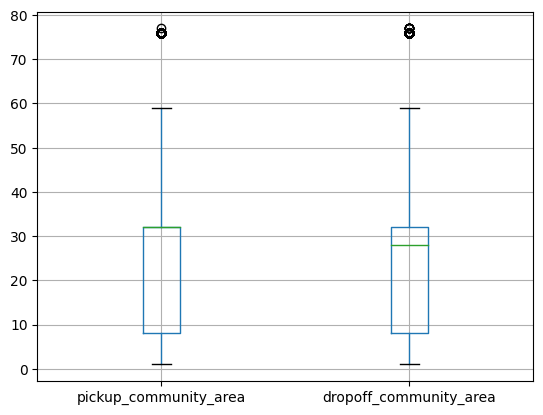

In [20]:
boxplot = df.boxplot(column=['pickup_community_area','dropoff_community_area'])

In [21]:
df.dropna(inplace=True)
df.shape

(20000, 14)

In [22]:
# Calculate the median
median_pickup = df['pickup_community_area'].median()
median_dropoff = df['dropoff_community_area'].median()

In [23]:
# Winsorization for pickup_community_area
data_pickup = df['pickup_community_area']
lower_limit_pickup = np.percentile(data_pickup, 5)  
upper_limit_pickup = np.percentile(data_pickup, 90)  

df['pickup_community_area'] = np.where((data_pickup < lower_limit_pickup) | (data_pickup > upper_limit_pickup), median_pickup, data_pickup)

# Updated boxplot with outliers replaced by median
# updated_boxplot = df.boxplot(column=['pickup_community_area', 'dropoff_community_area'])

In [24]:
# Winsorization for dropoff_community_area
data_dropoff = df['dropoff_community_area']
lower_limit_dropoff = np.percentile(data_dropoff, 5)  
upper_limit_dropoff = np.percentile(data_dropoff, 90)  

df['dropoff_community_area'] = np.where((data_dropoff < lower_limit_dropoff) | (data_dropoff > upper_limit_dropoff), median_dropoff, data_dropoff)

# Updated boxplot with outliers replaced by median
# updated_boxplot = df.boxplot(column=['pickup_community_area', 'dropoff_community_area'])

In [25]:
def calculate_distance(row):
    return haversine((row['pickup_latitude'], row['pickup_longitude']),
                      (row['dropoff_latitude'], row['dropoff_longitude']),
                      unit='m')

# Generate lineal distance field
df['distance'] = df.apply(calculate_distance, axis=1)

In [26]:
df.head()

trip_start_timestamp  pickup_census_tract  dropoff_census_tract  \
0  2018-10-26 18:45:00          17031080201           17031081100   
1  2018-10-18 22:15:00          17031071500           17031081500   
2  2018-10-26 09:30:00          17031071300           17031839100   
3  2018-10-18 20:30:00          17031161000           17031031400   
4  2018-10-19 14:30:00          17031080300           17031280100   

  pickup_community_area dropoff_community_area   fare  pickup_latitude  \
0                     8                      8   5.50        41.909496   
1                  32.0                      8   7.25        41.914616   
2                  32.0                     32  11.75        41.921778   
3                    16                   28.0  14.25        41.949974   
4                     8                     28  10.75        41.907492   

   pickup_longitude                       pickup_location  dropoff_latitude  \
0        -87.630964   POINT (-87.630963601 41.9094956686)         41.900221   
1        -87.631717  POINT (-87.6317173661 41.9146162864)         41.892508   
2        -87.641460  POINT (-87.6414597588 41.9217783562)         41.880994   
3        -87.730684  POINT (-87.7306842554 41.9499744545)         41.962179   
4        -87.635760  POINT (-87.6357600901 41.9074919303)         41.885300   

   dropoff_longitude                      dropoff_location  weekday  time  \
0         -87.629105  POINT (-87.6291051864 41.9002212967)        4    75   
1         -87.626215  POINT (-87.6262149064 41.8925077809)        3    89   
2         -87.632746  POINT (-87.6327464887 41.8809944707)        4    38   
3         -87.645379   POINT (-87.6453787624 41.962178629)        3    82   
4         -87.642808  POINT (-87.6428084655 41.8853000224)        4    58   

      distance  
0  1042.669793  
1  2500.177813  
2  4591.944450  
3  7183.349289  
4  2535.653490

In [27]:
df[:26]

trip_start_timestamp  pickup_census_tract  dropoff_census_tract  \
0   2018-10-26 18:45:00          17031080201           17031081100   
1   2018-10-18 22:15:00          17031071500           17031081500   
2   2018-10-26 09:30:00          17031071300           17031839100   
3   2018-10-18 20:30:00          17031161000           17031031400   
4   2018-10-19 14:30:00          17031080300           17031280100   
5   2018-10-25 20:15:00          17031243500           17031980000   
6   2018-10-19 11:00:00          17031080201           17031839100   
7   2018-10-26 00:15:00          17031842300           17031842300   
8   2018-10-26 03:00:00          17031842200           17031081800   
9   2018-10-09 17:45:00          17031839000           17031839000   
10  2018-10-09 19:15:00          17031080201           17031080202   
11  2018-10-26 18:45:00          17031832600           17031832600   
12  2018-10-09 22:45:00          17031243500           17031071400   
13  2018-10-18 16:45:00          17031841900           17031980000   
14  2018-10-26 00:15:00          17031830700           17031031200   
15  2018-10-26 08:30:00          17031071400           17031071400   
16  2018-10-26 20:00:00          17031071500           17031832500   
17  2018-10-18 21:00:00          17031833100           17031833100   
18  2018-10-19 12:15:00          17031063200           17031833100   
19  2018-10-18 18:00:00          17031841900           17031320400   
20  2018-10-26 10:00:00          17031839000           17031839100   
21  2018-10-09 18:30:00          17031071400           17031330100   
22  2018-10-26 17:30:00          17031071400           17031081500   
23  2018-10-19 10:15:00          17031841900           17031980100   
24  2018-10-26 08:45:00          17031063302           17031320100   
25  2018-10-10 10:15:00          17031839000           17031081403   

   pickup_community_area dropoff_community_area   fare  pickup_latitude  \
0                      8                      8   5.50        41.909496   
1                   32.0                      8   7.25        41.914616   
2                   32.0                     32  11.75        41.921778   
3                     16                   28.0  14.25        41.949974   
4                      8                     28  10.75        41.907492   
5                     24                   28.0  39.25        41.892658   
6                      8                     32   7.75        41.909496   
7                     24                     24   3.25        41.898306   
8                      8                      8  11.00        41.904935   
9                     32                     32   3.25        41.871016   
10                     8                      8  15.50        41.909496   
11                  32.0                   28.0   3.25        41.914747   
12                    24                   28.0  10.00        41.892658   
13                    28                   28.0  53.25        41.867902   
14                  32.0                   28.0   4.25        41.958056   
15                  32.0                   28.0   3.25        41.922083   
16                  32.0                   28.0  11.25        41.914616   
17                    28                     28   3.25        41.879067   
18                  32.0                     28  19.75        41.938391   
19                    28                     32   7.25        41.867902   
20                    32                     32   5.75        41.871016   
21                  32.0                     33  17.25        41.922083   
22                  32.0                      8  12.75        41.922083   
23                    28                   28.0  32.25        41.867902   
24                  32.0                     32  14.25        41.934762   
25                    32                      8   8.25        41.871016   

    pickup_longitude                            pickup_location  \
0         -87.63096

In [28]:
df.drop(columns=(['pickup_location', 'dropoff_location']), inplace=True, axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_census_tract     20000 non-null  Int64         
 2   dropoff_census_tract    20000 non-null  Int64         
 3   pickup_community_area   20000 non-null  object        
 4   dropoff_community_area  20000 non-null  object        
 5   fare                    20000 non-null  float64       
 6   pickup_latitude         20000 non-null  float64       
 7   pickup_longitude        20000 non-null  float64       
 8   dropoff_latitude        20000 non-null  float64       
 9   dropoff_longitude       20000 non-null  float64       
 10  weekday                 20000 non-null  int64         
 11  time                    20000 non-null  int64         
 12  distance                20000 non-null  float6

In [30]:
df.drop(columns=(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']), inplace=True, axis=1)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trip_start_timestamp    20000 non-null  datetime64[ns]
 1   pickup_census_tract     20000 non-null  Int64         
 2   dropoff_census_tract    20000 non-null  Int64         
 3   pickup_community_area   20000 non-null  object        
 4   dropoff_community_area  20000 non-null  object        
 5   fare                    20000 non-null  float64       
 6   weekday                 20000 non-null  int64         
 7   time                    20000 non-null  int64         
 8   distance                20000 non-null  float64       
dtypes: Int64(2), datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 1.4+ MB


In [32]:
df.drop('trip_start_timestamp', inplace=True, axis=1)
df['pickup_community_area'] = df['pickup_community_area'].astype(int)
df['dropoff_community_area'] = df['dropoff_community_area'].astype(int)
X = df.drop('fare', axis=1)
y = df['fare']
y = np.asarray(y, dtype=np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [50]:
df.head()

pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0          17031080201           17031081100                      8   
1          17031071500           17031081500                     32   
2          17031071300           17031839100                     32   
3          17031161000           17031031400                     16   
4          17031080300           17031280100                      8   

   dropoff_community_area   fare  weekday  time     distance  
0                       8   5.50        4    75  1042.669793  
1                       8   7.25        3    89  2500.177813  
2                      32  11.75        4    38  4591.944450  
3                      28  14.25        3    82  7183.349289  
4                      28  10.75        4    58  2535.653490

In [33]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor()

cb.fit(X_train, y_train, verbose=False)

In [34]:
y_pred_cb = cb.predict(X_test).flatten()

In [35]:
df_test_cb = pd.DataFrame(data={"Actual test":y_test, "Prediction":y_pred_cb})
df_test_cb

Actual test  Prediction
0            8.50    9.094125
1            9.00    8.982083
2            4.75    6.386860
3            6.50    5.848922
4            5.25    5.935763
...           ...         ...
3995        10.75   11.123059
3996         7.25    7.928745
3997         7.75    7.084396
3998         7.00    6.890793
3999        45.75   47.203707

[4000 rows x 2 columns]

In [36]:
mse = mean_squared_error(y_pred_cb, y_test)
rmse = root_mean_squared_error(y_pred_cb, y_test)
mae = mean_absolute_error(y_pred_cb, y_test)
mape = mean_absolute_percentage_error(y_pred_cb, y_test)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MSE: 10.904423436389978
RMSE: 3.3021846460169333
MAE: 1.3111307660065563
MAPE: 0.14497509024329389


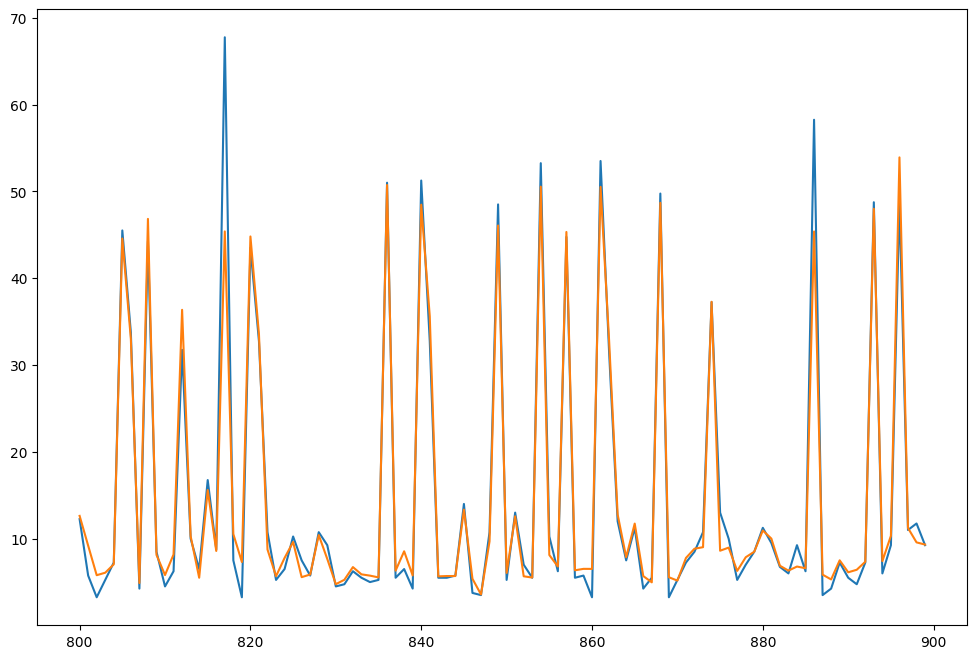

In [37]:
plt.figure(figsize=(12,8))
plt.plot(df_test_cb['Actual test'][800:900], label="A. Test")
plt.plot(df_test_cb['Prediction'][800:900], label="prediction")
plt.show()

Learning rate set to 0.042571
0:	learn: 13.0821910	total: 986us	remaining: 985ms
1:	learn: 12.6262347	total: 1.86ms	remaining: 927ms
2:	learn: 12.2151499	total: 2.73ms	remaining: 908ms
3:	learn: 11.7877289	total: 3.62ms	remaining: 901ms
4:	learn: 11.3747192	total: 4.49ms	remaining: 893ms
5:	learn: 10.9976905	total: 5.29ms	remaining: 876ms
6:	learn: 10.6248335	total: 6.11ms	remaining: 867ms
7:	learn: 10.2849817	total: 7.01ms	remaining: 870ms
8:	learn: 9.9628736	total: 7.95ms	remaining: 875ms
9:	learn: 9.6367633	total: 8.88ms	remaining: 879ms
10:	learn: 9.3262244	total: 9.28ms	remaining: 834ms
11:	learn: 9.0189240	total: 10.1ms	remaining: 835ms
12:	learn: 8.7361189	total: 11ms	remaining: 837ms
13:	learn: 8.4409771	total: 11.9ms	remaining: 837ms
14:	learn: 8.1807590	total: 12.4ms	remaining: 815ms
15:	learn: 7.9399586	total: 13.2ms	remaining: 814ms
16:	learn: 7.6997271	total: 14.2ms	remaining: 818ms
17:	learn: 7.4721946	total: 15ms	remaining: 819ms
18:	learn: 7.2657102	total: 16ms	remainin

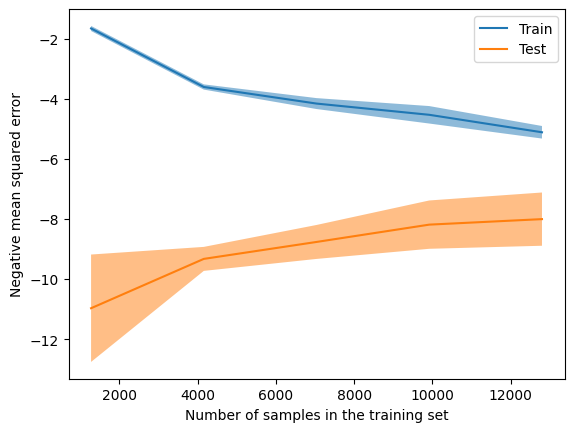

In [38]:
LearningCurveDisplay.from_estimator(cb, X_train, y_train, scoring = 'neg_mean_squared_error', verbose=False)
plt.show()

In [39]:
from sklearn.model_selection import GridSearchCV
import joblib

param_grid_cb = {
    'learning_rate': [0.01, 0.1, 1],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300]
}

cb_model = GridSearchCV(CatBoostRegressor(), param_grid=param_grid_cb, scoring='neg_mean_squared_error', cv=5, verbose=False, n_jobs=-1)

# Fit the model in parallel using all available CPU cores
with joblib.parallel_backend('threading', n_jobs=-1):
    cb_model.fit(X_train, y_train)

# Get the best parameters and initialize the tuned SVR model
best_params = cb_model.best_params_
cb_model_tuned = CatBoostRegressor(**best_params)

# Fit the tuned model
cb_model_tuned.fit(X_train, y_train, verbose=False)

0:	learn: 13.2758210	total: 73.9ms	remaining: 7.31s
1:	learn: 13.1525468	total: 76.5ms	remaining: 3.75s
0:	learn: 12.2195575	total: 45.3ms	remaining: 4.48s
0:	learn: 13.2372214	total: 63.3ms	remaining: 6.27s
2:	learn: 13.0357523	total: 78.3ms	remaining: 2.53s
0:	learn: 13.2890894	total: 64.7ms	remaining: 6.41s
0:	learn: 12.1349365	total: 38.3ms	remaining: 3.79s
0:	learn: 13.3585893	total: 27.3ms	remaining: 2.7s
1:	learn: 11.0356283	total: 40.1ms	remaining: 1.96s
1:	learn: 13.1657880	total: 67.2ms	remaining: 3.29s
1:	learn: 13.1154069	total: 68.6ms	remaining: 3.36s
1:	learn: 11.1030590	total: 51.5ms	remaining: 2.52s
2:	learn: 13.0459243	total: 70.1ms	remaining: 2.27s
1:	learn: 13.2369852	total: 31.4ms	remaining: 1.54s
2:	learn: 10.1277885	total: 54.5ms	remaining: 1.76s
0:	learn: 12.2636382	total: 20.7ms	remaining: 2.05s
3:	learn: 12.9178634	total: 87.3ms	remaining: 2.1s
2:	learn: 12.9970307	total: 72.9ms	remaining: 2.36s
3:	learn: 12.9275792	total: 73.5ms	remaining: 1.76s
3:	learn: 12.8

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [-33.76338584  -8.02238358  -8.38524809          nan          nan
  -8.78371738  -8.97528345  -7.91645856  -9.03977446 -33.32927483
          nan  -8.68206746 -12.092709            nan  -9.32516086
  -8.8319473   -7.95644217  -9.67425363 -33.28235362  -7.9563207
  -9.2644905  -12.04208091  -8.0080268   -9.93637968  -8.7899914
  -8.05138347          nan]
  warnings.warn(


0:	learn: 12.1912674	total: 1.73ms	remaining: 517ms
1:	learn: 11.0990445	total: 3.21ms	remaining: 478ms
2:	learn: 10.1011918	total: 4.71ms	remaining: 466ms
3:	learn: 9.2280526	total: 6.21ms	remaining: 460ms
4:	learn: 8.4243164	total: 7.63ms	remaining: 450ms
5:	learn: 7.7083240	total: 9.31ms	remaining: 456ms
6:	learn: 7.0883860	total: 10.7ms	remaining: 447ms
7:	learn: 6.5411553	total: 12.1ms	remaining: 440ms
8:	learn: 6.0436655	total: 13.5ms	remaining: 438ms
9:	learn: 5.6157681	total: 15ms	remaining: 434ms
10:	learn: 5.2449358	total: 16.4ms	remaining: 431ms
11:	learn: 4.9001090	total: 18ms	remaining: 431ms
12:	learn: 4.6029471	total: 19.4ms	remaining: 429ms
13:	learn: 4.3450882	total: 20.9ms	remaining: 426ms
14:	learn: 4.1230134	total: 22.3ms	remaining: 424ms
15:	learn: 3.9278757	total: 23.7ms	remaining: 420ms
16:	learn: 3.7683370	total: 25.1ms	remaining: 417ms
17:	learn: 3.6282803	total: 26.5ms	remaining: 416ms
18:	learn: 3.5133735	total: 28ms	remaining: 414ms
19:	learn: 3.4141325	tota

In [40]:
cb_model_tuned_pred = cb_model_tuned.predict(X_test).flatten()
mse = mean_squared_error(cb_model_tuned_pred, y_test)
rmse = root_mean_squared_error(cb_model_tuned_pred, y_test)
mae = mean_absolute_error(cb_model_tuned_pred, y_test)
mape = mean_absolute_percentage_error(cb_model_tuned_pred, y_test)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MSE: 10.592180756975324
RMSE: 3.25456306698385
MAE: 1.3362648756068665
MAPE: 0.14615414878481978


0:	learn: 12.4266543	total: 629us	remaining: 188ms
1:	learn: 11.4317771	total: 1.43ms	remaining: 212ms
2:	learn: 10.5627294	total: 1.92ms	remaining: 191ms
3:	learn: 9.7168116	total: 2.54ms	remaining: 188ms
4:	learn: 8.9384325	total: 3.08ms	remaining: 182ms
5:	learn: 8.2960452	total: 3.58ms	remaining: 175ms
6:	learn: 7.6921354	total: 4.08ms	remaining: 171ms
7:	learn: 7.1552460	total: 4.57ms	remaining: 167ms
8:	learn: 6.7010818	total: 5.1ms	remaining: 165ms
9:	learn: 6.2768012	total: 5.59ms	remaining: 162ms
10:	learn: 5.9112418	total: 6.11ms	remaining: 161ms
11:	learn: 5.5928581	total: 6.63ms	remaining: 159ms
12:	learn: 5.2992970	total: 7.12ms	remaining: 157ms
13:	learn: 5.0553551	total: 7.61ms	remaining: 155ms
14:	learn: 4.8406847	total: 8.13ms	remaining: 155ms
15:	learn: 4.6638764	total: 8.58ms	remaining: 152ms
16:	learn: 4.5010199	total: 9.1ms	remaining: 152ms
17:	learn: 4.3589710	total: 9.6ms	remaining: 150ms
18:	learn: 4.2316376	total: 10.2ms	remaining: 152ms
19:	learn: 4.1209849	to

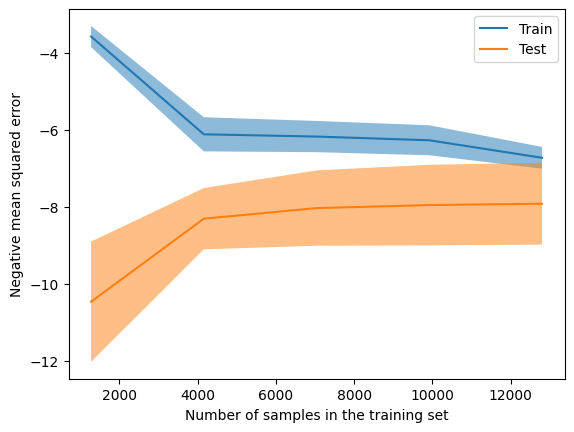

In [41]:
LearningCurveDisplay.from_estimator(cb_model_tuned, X_train, y_train, scoring = 'neg_mean_squared_error', verbose=False)
plt.show()

In [42]:
cb_model_tuned_pred
df_test_tuned_CB = pd.DataFrame(data={"Actual test":y_test, "Prediction":cb_model_tuned_pred})
df_test_tuned_CB

Actual test  Prediction
0            8.50    8.695337
1            9.00    8.670906
2            4.75    6.245583
3            6.50    5.853398
4            5.25    6.046805
...           ...         ...
3995        10.75   11.073461
3996         7.25    8.811044
3997         7.75    6.961433
3998         7.00    6.898186
3999        45.75   46.787561

[4000 rows x 2 columns]

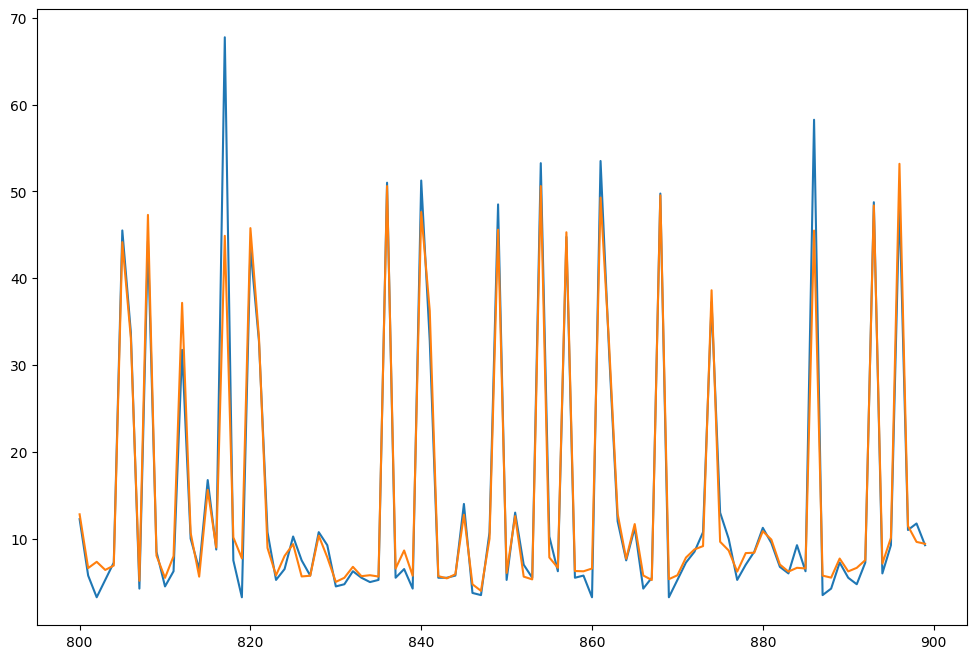

In [43]:
plt.figure(figsize=(12,8))
plt.plot(df_test_tuned_CB['Actual test'][800:900], label="A. Test")
plt.plot(df_test_tuned_CB['Prediction'][800:900], label="prediction")
plt.show()

0:	learn: 12.4266543	total: 685us	remaining: 205ms
1:	learn: 11.4317771	total: 1.6ms	remaining: 238ms
2:	learn: 10.5627294	total: 2.14ms	remaining: 212ms
3:	learn: 9.7168116	total: 2.63ms	remaining: 195ms
4:	learn: 8.9384325	total: 3.2ms	remaining: 189ms
5:	learn: 8.2960452	total: 3.66ms	remaining: 179ms
6:	learn: 7.6921354	total: 4.18ms	remaining: 175ms
7:	learn: 7.1552460	total: 4.7ms	remaining: 171ms
8:	learn: 6.7010818	total: 5.22ms	remaining: 169ms
9:	learn: 6.2768012	total: 5.76ms	remaining: 167ms
10:	learn: 5.9112418	total: 6.24ms	remaining: 164ms
11:	learn: 5.5928581	total: 6.77ms	remaining: 162ms
12:	learn: 5.2992970	total: 7.27ms	remaining: 160ms
13:	learn: 5.0553551	total: 7.77ms	remaining: 159ms
14:	learn: 4.8406847	total: 8.26ms	remaining: 157ms
15:	learn: 4.6638764	total: 8.67ms	remaining: 154ms
16:	learn: 4.5010199	total: 9.18ms	remaining: 153ms
17:	learn: 4.3589710	total: 9.65ms	remaining: 151ms
18:	learn: 4.2316376	total: 10.2ms	remaining: 151ms
19:	learn: 4.1209849	to

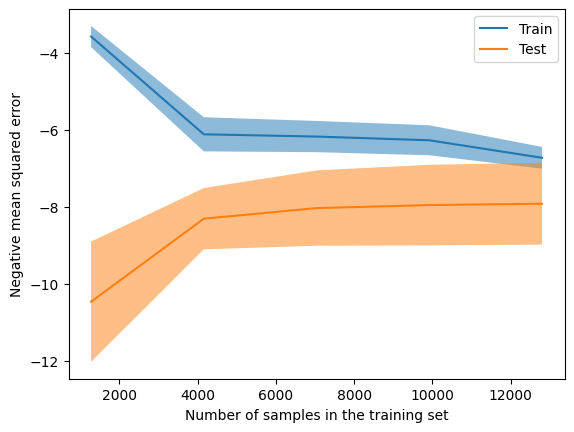

In [44]:
LearningCurveDisplay.from_estimator(cb_model_tuned, X_train, y_train, scoring = 'neg_mean_squared_error', verbose=False)
plt.show()

In [45]:
with open('catboostModel.pkl', 'wb') as f:
    pickle.dump(cb_model_tuned, f)